In [134]:
# Copyright (c) Facebook, Inc. and its affiliates.
# 
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
# 
#     http://www.apache.org/licenses/LICENSE-2.0
# 
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
import os
import sys
import glob
import argparse
import cv2
import random
import colorsys
import requests
import pandas as pd
import pprint
from io import BytesIO
import tqdm
import gc
import psutil

In [2]:
import skimage.io
from skimage.measure import find_contours
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms as pth_transforms
import numpy as np
from PIL import Image
import warnings
from sklearn.exceptions import DataConversionWarning
warnings.filterwarnings(action='ignore', category=DataConversionWarning)
from sklearn import manifold, model_selection, preprocessing, metrics, decomposition
from sklearn import linear_model, ensemble, neural_network, neighbors

In [73]:
import argparse
import time
import math
from threading import Thread
import numpy as np
import cv2
import pprint
import importlib
import pandas as pd
from pandas.io import gbq
import pydata_google_auth
import matplotlib.pyplot as plt

from aperturedb import Connector, Status, PyTorchDataset

# Database information for connecting to the ApertureDB database
class dbinfo():
    
    DB_HOST="localhost"
    DB_PORT=10009
    DB_USER="admin"
    DB_PASSWORD="admin"

In [67]:
# Testing the connection
db = Connector.Connector("localhost", 10009, user=dbinfo.DB_USER, password=dbinfo.DB_PASSWORD)
status = Status.Status(db)

total_images = status.count_images()
print(total_images)

11327211


In [3]:
import utils
import vision_transformer as vits

In [4]:
def apply_mask(image, mask, color, alpha=0.5):
    for c in range(3):
        image[:, :, c] = image[:, :, c] * (1 - alpha * mask) + alpha * mask * color[c] * 255
    return image

In [5]:
def random_colors(N, bright=True):
    """
    Generate random colors.
    """
    brightness = 1.0 if bright else 0.7
    hsv = [(i / N, 1, brightness) for i in range(N)]
    colors = list(map(lambda c: colorsys.hsv_to_rgb(*c), hsv))
    random.shuffle(colors)
    return colors

In [6]:
def display_instances(image, mask, fname="test", figsize=(5, 5), blur=False, contour=True, alpha=0.5):
    fig = plt.figure(figsize=figsize, frameon=False)
    ax = plt.Axes(fig, [0., 0., 1., 1.])
    ax.set_axis_off()
    fig.add_axes(ax)
    ax = plt.gca()

    N = 1
    mask = mask[None, :, :]
    # Generate random colors
    colors = random_colors(N)

    # Show area outside image boundaries.
    height, width = image.shape[:2]
    margin = 0
    ax.set_ylim(height + margin, -margin)
    ax.set_xlim(-margin, width + margin)
    ax.axis('off')
    masked_image = image.astype(np.uint32).copy()
    for i in range(N):
        color = colors[i]
        _mask = mask[i]
        if blur:
            _mask = cv2.blur(_mask,(10,10))
        # Mask
        masked_image = apply_mask(masked_image, _mask, color, alpha)
        # Mask Polygon
        # Pad to ensure proper polygons for masks that touch image edges.
        if contour:
            padded_mask = np.zeros((_mask.shape[0] + 2, _mask.shape[1] + 2))
            padded_mask[1:-1, 1:-1] = _mask
            contours = find_contours(padded_mask, 0.5)
            for verts in contours:
                # Subtract the padding and flip (y, x) to (x, y)
                verts = np.fliplr(verts) - 1
                p = Polygon(verts, facecolor="none", edgecolor=color)
                ax.add_patch(p)
    ax.imshow(masked_image.astype(np.uint8), aspect='auto')
    fig.savefig(fname)
    print(f"{fname} saved.")
    return

In [27]:
class VisAttn:
    def __init__(self, 
                arch = 'vit_small', 
                patch_size = 16,
                pretrained_weights = None,
                checkpoint_key = 'teacher',
                image_size = (480, 480),
                output_dir = '.',
                threshold = None):
        self.arch = arch
        self.patch_size = patch_size
        self.pretrained_weights = pretrained_weights
        self.checkpoint_key = checkpoint_key
        self.image_size = image_size
        self.output_dir = output_dir
        self.threshold = threshold
        
    def prepareTransform(self):
        """
        """
        transform = pth_transforms.Compose([
        pth_transforms.Resize(self.image_size),
        pth_transforms.ToTensor(),
        pth_transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
    ])
        self.transform = transform
        
        
    def prepareModel(self):
        """
        Given current parameters, prepare the model
        
        """
        # Prepare the model for investigation

        device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
        self.device = device
        # build model
        model = vits.__dict__[self.arch](patch_size=self.patch_size, num_classes=0)
        for p in model.parameters():
            p.requires_grad = False
        model.eval()
        model.to(device)
        if os.path.isfile(self.pretrained_weights):
            state_dict = torch.load(self.pretrained_weights, map_location="cpu")
            if self.checkpoint_key is not None and self.checkpoint_key in state_dict:
                print(f"Take key {self.checkpoint_key} in provided checkpoint dict")
                state_dict = state_dict[self.checkpoint_key]
            # remove `module.` prefix
            state_dict = {k.replace("module.", ""): v for k, v in state_dict.items()}
            # remove `backbone.` prefix induced by multicrop wrapper
            state_dict = {k.replace("backbone.", ""): v for k, v in state_dict.items()}
            msg = model.load_state_dict(state_dict, strict=False)
            print('Pretrained weights found at {} and loaded with msg: {}'.format(self.pretrained_weights, msg))
        else:
            print("Please use the `--pretrained_weights` argument to indicate the path of the checkpoint to evaluate.")
            url = None
            if self.arch == "vit_small" and self.patch_size == 16:
                url = "dino_deitsmall16_pretrain/dino_deitsmall16_pretrain.pth"
            elif self.arch == "vit_small" and self.patch_size == 8:
                url = "dino_deitsmall8_300ep_pretrain/dino_deitsmall8_300ep_pretrain.pth"  # model used for visualizations in our paper
            elif self.arch == "vit_base" and self.patch_size == 16:
                url = "dino_vitbase16_pretrain/dino_vitbase16_pretrain.pth"
            elif self.arch == "vit_base" and self.patch_size == 8:
                url = "dino_vitbase8_pretrain/dino_vitbase8_pretrain.pth"
            if url is not None:
                print("Since no pretrained weights have been provided, we load the reference pretrained DINO weights.")
                state_dict = torch.hub.load_state_dict_from_url(url="https://dl.fbaipublicfiles.com/dino/" + url)
                model.load_state_dict(state_dict, strict=True)
            else:
                print("There is no reference weights available for this model => We use random weights.")
        self.model = model

    def prepare(self):
        self.prepareModel()
        self.prepareTransform()
        
    def __readyImage(self, image_path):
        # open image
        if image_path is None:
            # user has not specified any image - we use our own image
            print("Please use the `--image_path` argument to indicate the path of the image you wish to visualize.")
            print("Since no image path have been provided, we take the first image in our paper.")
            response = requests.get("https://dl.fbaipublicfiles.com/dino/img.png")
            img = Image.open(BytesIO(response.content))
            img = img.convert('RGB')
        elif os.path.isfile(image_path):
            with open(image_path, 'rb') as f:
                img = Image.open(f)
                img = img.convert('RGB')
        else:
            print(f"Provided image path {image_path} is non valid.")
            sys.exit(1)

        img = self.transform(img)

        # make the image divisible by the patch size
        w, h = img.shape[1] - img.shape[1] % self.patch_size, img.shape[2] - img.shape[2] % self.patch_size
        img = img[:, :w, :h].unsqueeze(0)

        w_featmap = img.shape[-2] // self.patch_size
        h_featmap = img.shape[-1] // self.patch_size
        return img, w_featmap, h_featmap
    
    def getAttention(self, image_path):
        img, w_featmap, h_featmap = self.__readyImage(image_path)
        
        attentions = self.model.get_last_selfattention(img.to(self.device))

        nh = attentions.shape[1] # number of head

        # we keep only the output patch attention
        attentions = attentions[0, :, 0, 1:].reshape(nh, -1)

        if self.threshold is not None:
            # we keep only a certain percentage of the mass
            val, idx = torch.sort(attentions)
            val /= torch.sum(val, dim=1, keepdim=True)
            cumval = torch.cumsum(val, dim=1)
            th_attn = cumval > (1 - self.threshold)
            idx2 = torch.argsort(idx)
            for head in range(nh):
                th_attn[head] = th_attn[head][idx2[head]]
            th_attn = th_attn.reshape(nh, w_featmap, h_featmap).float()
            # interpolate
            th_attn = nn.functional.interpolate(th_attn.unsqueeze(0), scale_factor=self.patch_size, mode="nearest")[0].cpu().numpy()

        attentions = attentions.reshape(nh, w_featmap, h_featmap)
        attentions = nn.functional.interpolate(attentions.unsqueeze(0), scale_factor=self.patch_size, mode="nearest")[0].cpu().numpy()

        return attentions
    def getIntermediate(self, image_path, n = 1):
        img, w_featmap, h_featmap = self.__readyImage(image_path)
        output = self.model.get_intermediate_layers(img.to(self.device), n = n)
        output = np.array([q.cpu().numpy() for q in output])
        return output
    def getClsToken(self, image_path, n = 1, binarize_threshold = None):
        output = self.getIntermediate(image_path, n = n)
        cls = output[:,0,0]
        if (binarize_threshold is not None):
            cls = cls > binarize_threshold
        return cls        
        
defaultPars = VisAttn()




In [69]:
# # Select the weights here # #
# ImageNet pre-trained
pretrained_weights = ""

# 120k, 0.669 loss, 8k dim
# pretrained_weights = '/home/DXB05HN/model_pts/dino/checkpoint.pth'


# Build the object for easy use of post-processing steps
myAttnVis = VisAttn(pretrained_weights = pretrained_weights)
myAttnVis.prepare()

# Get all the images from a given directory that might be inspected
fns = glob.glob("/home/DXB05HN/data/HDCLIPDataset200k/livingroombest/*.jpg")

Please use the `--pretrained_weights` argument to indicate the path of the checkpoint to evaluate.
Since no pretrained weights have been provided, we load the reference pretrained DINO weights.


In [77]:
# File directory
file_dir = "/home/DXB05HN/data/HDCLIPDataset200k/livingroombest"

# read in the dataframe of information
df = pd.read_csv("/home/DXB05HN/data/HDCLIPDataset200k/product_all.csv")
df['image_full'] = df['image'].apply(lambda x: os.path.join(file_dir, x))

print(df.columns.to_list())
df[['image', 'image_full', 'taxonomy']].head()

df['taxonomy_last'] = df['taxonomy'].apply(lambda x: x.split('>')[-1])
print(df['taxonomy_last'].unique())

# This is the finest grain taxonomy of classes
labels, levels = df['taxonomy'].factorize()

# This is less granular taxonomy of classes
labels, levels = df['taxonomy_last'].factorize()
levels = np.array(levels)
_, level_weights = np.unique(labels, return_counts = True)
print("Counts", level_weights)

['image_name_x', 'product_title', 'image', 'has_image', 'caption_x', 'image_no_a', 'image_path', 'description', 'omsid', 'taxonomy', 'image_name_y', 'product_description', 'caption_y', 'image_full']
['Area Rugs' 'End Tables' 'Sofas' 'Coffee Tables' 'Table Lamps'
 'Accent Chairs']
Counts [103869   4105   1347   2666   4571   3941]


In [64]:
df[['product_title']].head()

,product_title
0,Abstract Gold/Gray 6 ft. x 6 ft. Square Border...
1,Agoja Contemporary Diamonds Black 2 ft. 6 in. ...
2,Madison White/Royal Blue 4 ft. x 4 ft. Square ...
3,LYNDON 116 GRAPHITE 3 FT. 3 IN. X 5 FT. 1 IN. ...
4,Eco Navy 4 ft. x 5 ft. 3 in. Outdoor Area Rug


In [57]:
# Get class tokens over a number of images
gc.collect()
cls_tokens = []
n_files = 3000
for ind, row in tqdm.tqdm(df.iloc[:n_files].iterrows(), total = n_files):
    cls_tokens.append(myAttnVis.getClsToken(row['image_full'], n = 1)[0])
#     cls_tokens.append(myAttnVis.getForward(row['image_full'])[0])
cls_tokens = np.array(cls_tokens)

  0%|                                                                                                       | 0/3000 [00:00<?, ?it/s]/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:3635: UserWarning: Default upsampling behavior when mode=bicubic is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)
/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:3680: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  "The default behavior for interpolate/upsample with float scale_factor changed "
1

In [60]:
# Parameters of the run
rand_state = 18039
max_cat_samples = 200 # Any more samples than this and we drop them

# Data splitter
splitter = model_selection.StratifiedShuffleSplit(n_splits = 4, test_size = 0.2, random_state = rand_state)

# Current data to use
these_data = cls_tokens[:2000].copy()
# these_data = cls_tokens[:2000].copy() > 0


# Get the labels for the current tokens to be considered
these_labels = labels[:len(these_data)]


# Custom filter for data selection
these_data_temp = []
these_labels_temp = []
for i in np.unique(these_labels):
    inds_all = np.argwhere(these_labels == i)[:,0][:max_cat_samples]
    these_data_temp.append(these_data[inds_all])
    these_labels_temp.append(these_labels[inds_all])

these_data = np.concatenate(these_data_temp, axis = 0)
these_labels = np.concatenate(these_labels_temp, axis = 0)

unique_labels, unique_label_counts = np.unique(these_labels, return_counts = True)
print(unique_label_counts)



# Build the classifier
clf_list = {}
clfLR = linear_model.LogisticRegression(random_state = rand_state, max_iter = 1000)
clf_list['LinReg'] = clfLR
clfET = ensemble.ExtraTreesClassifier(random_state = rand_state, min_samples_split = 4, n_estimators = 100)
clf_list['ET'] = clfET
clfMLP = neural_network.MLPClassifier([384, 128, 16], random_state = rand_state)
clf_list['MLP'] = clfMLP
clfKNN = neighbors.KNeighborsClassifier()
clf_list['KNN'] = clfKNN

scores_all = {}
for mtype in clf_list:
    clf = clf_list[mtype]
    # Loop through splits and store scores of trained classifier. Plot confusion matrix for each as well
    scores = []
    for i, (train_index, test_index) in enumerate(splitter.split(these_data, these_labels)):
        X, y = these_data[train_index], these_labels[train_index]

        # Initial build of the two components in preprocessing
        # pca = decomposition.PCA(n_components = 128).fit(X)
        # scaler = preprocessing.StandardScaler().fit(pca.transform(X))
        scaler = preprocessing.StandardScaler().fit(X)


        # Build preprocessing functions
        # preproc = lambda x: scaler.transform(pca.transform(x))
        preproc = lambda x: scaler.transform(x)
#         preproc = lambda x: x

        # Scaling
        clf = clf.fit(preproc(X), y)

        # Test data
        X_t, y_t = these_data[test_index], these_labels[test_index]

        # Scaling
        scores.append(clf.score(preproc(X_t), y_t))

        # Confusion matrix generation
#         confmat = metrics.confusion_matrix(y_t, clf.predict(preproc(X_t)), labels=clf.classes_)
#         disp = metrics.ConfusionMatrixDisplay(confusion_matrix=confmat, display_labels=clf.classes_)
#         disp.plot()
    scores_all[mtype] = {'avg': np.mean(scores).round(3), 'cv_std': np.std(np.array(scores)).round(3)}
    
pprint.pprint(scores_all)
# print(metrics.accuracy_score(y_t, np.ones_like(y_t) * np.mean(y)))

# embed = manifold.TSNE().fit_transform(cls_tokens)
del these_data, these_labels

[200  82  18  54  89  54]
{'ET': {'avg': 0.872, 'cv_std': 0.019},
 'KNN': {'avg': 0.847, 'cv_std': 0.026},
 'LinReg': {'avg': 0.883, 'cv_std': 0.036},
 'MLP': {'avg': 0.903, 'cv_std': 0.036}}


In [108]:
print(these_data.shape)
print(these_labels.shape)
np.argwhere(these_labels == 0)[:,0][:100].shape
print(these_data_temp[0].shape)
print(np.concatenate(these_data_temp, axis = 0).shape)

(397, 384)
(2000,)
(100, 384)
(397, 384)


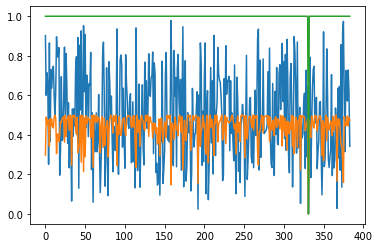

In [34]:
fig, ax = plt.subplots(1,1)
ax.cla()
ax.plot(np.mean(cls_tokens, axis = 0))
ax.plot(np.std(cls_tokens, axis = 0))
ax.plot(np.max(cls_tokens, axis = 0))

In [90]:
# This code is pulled mostly from the DINO Attention code
class ModelInspectorApertureDB:
    def __init__(self, 
                arch = 'vit_small', 
                patch_size = 16,
                pretrained_weights = None,
                checkpoint_key = 'teacher',
                image_size = (480, 480),
                output_dir = '.',
                threshold = None,
                aperturedb_dataset = None):
        self.arch = arch
        self.patch_size = patch_size
        self.pretrained_weights = pretrained_weights
        self.checkpoint_key = checkpoint_key
        self.image_size = image_size
        self.output_dir = output_dir
        self.threshold = threshold
        self.aperturedb_dataset = aperturedb_dataset
        
    def prepareTransform(self):
        """
        """
        transform = pth_transforms.Compose([
        pth_transforms.Resize(self.image_size),
        pth_transforms.ToTensor(),
        pth_transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
    ])
        self.transform = transform
        
        
    def prepareModel(self):
        """
        Given current parameters, prepare the model
        
        """
        # Prepare the model for investigation

        device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
        self.device = device
        # build model
        model = vits.__dict__[self.arch](patch_size=self.patch_size, num_classes=0)
        for p in model.parameters():
            p.requires_grad = False
        model.eval()
        model.to(device)
        if os.path.isfile(self.pretrained_weights):
            state_dict = torch.load(self.pretrained_weights, map_location="cpu")
            if self.checkpoint_key is not None and self.checkpoint_key in state_dict:
                print(f"Take key {self.checkpoint_key} in provided checkpoint dict")
                state_dict = state_dict[self.checkpoint_key]
            # remove `module.` prefix
            state_dict = {k.replace("module.", ""): v for k, v in state_dict.items()}
            # remove `backbone.` prefix induced by multicrop wrapper
            state_dict = {k.replace("backbone.", ""): v for k, v in state_dict.items()}
            msg = model.load_state_dict(state_dict, strict=False)
            print('Pretrained weights found at {} and loaded with msg: {}'.format(self.pretrained_weights, msg))
        else:
            print("Please use the `--pretrained_weights` argument to indicate the path of the checkpoint to evaluate.")
            url = None
            if self.arch == "vit_small" and self.patch_size == 16:
                url = "dino_deitsmall16_pretrain/dino_deitsmall16_pretrain.pth"
            elif self.arch == "vit_small" and self.patch_size == 8:
                url = "dino_deitsmall8_300ep_pretrain/dino_deitsmall8_300ep_pretrain.pth"  # model used for visualizations in our paper
            elif self.arch == "vit_base" and self.patch_size == 16:
                url = "dino_vitbase16_pretrain/dino_vitbase16_pretrain.pth"
            elif self.arch == "vit_base" and self.patch_size == 8:
                url = "dino_vitbase8_pretrain/dino_vitbase8_pretrain.pth"
            if url is not None:
                print("Since no pretrained weights have been provided, we load the reference pretrained DINO weights.")
                state_dict = torch.hub.load_state_dict_from_url(url="https://dl.fbaipublicfiles.com/dino/" + url)
                model.load_state_dict(state_dict, strict=True)
            else:
                print("There is no reference weights available for this model => We use random weights.")
        self.model = model

    def prepare(self):
        self.prepareModel()
        self.prepareTransform()
        
    def __readyNextImage(self, index):

        # Get the next image and label from the dataset
        img, lbl = self.aperturedb_dataset[index]
        
        # Convert image from numpy array to PIL image
        img = Image.fromarray(img)
        
        # Transform according to transformation image
        img = self.transform(img)

        # make the image divisible by the patch size
        w, h = img.shape[1] - img.shape[1] % self.patch_size, img.shape[2] - img.shape[2] % self.patch_size
        img = img[:, :w, :h].unsqueeze(0)

        # Return shapes
        w_featmap = img.shape[-2] // self.patch_size
        h_featmap = img.shape[-1] // self.patch_size
        return img, w_featmap, h_featmap, lbl
    
    def getAttention(self, index):
        """
        Get the attention mask of the last layer of the model. If provided, 
        build a thresholded cumsum mask.
        """
        img, w_featmap, h_featmap, label = self.__readyNextImage(index)
        
        attentions = self.model.get_last_selfattention(img.to(self.device))

        nh = attentions.shape[1] # number of head

        # we keep only the output patch attention
        attentions = attentions[0, :, 0, 1:].reshape(nh, -1)

        if self.threshold is not None:
            # we keep only a certain percentage of the mass
            val, idx = torch.sort(attentions)
            val /= torch.sum(val, dim=1, keepdim=True)
            cumval = torch.cumsum(val, dim=1)
            th_attn = cumval > (1 - self.threshold)
            idx2 = torch.argsort(idx)
            for head in range(nh):
                th_attn[head] = th_attn[head][idx2[head]]
            th_attn = th_attn.reshape(nh, w_featmap, h_featmap).float()
            # interpolate
            th_attn = nn.functional.interpolate(th_attn.unsqueeze(0), scale_factor=self.patch_size, mode="nearest")[0].cpu().numpy()

        attentions = attentions.reshape(nh, w_featmap, h_featmap)
        attentions = nn.functional.interpolate(attentions.unsqueeze(0), scale_factor=self.patch_size, mode="nearest")[0].cpu().numpy()

        return attentions, label
    
    def getIntermediate(self, index, n = 1):
        img, w_featmap, h_featmap, label = self.__readyNextImage(index)
        output = self.model.get_intermediate_layers(img.to(self.device), n = n)
        output = np.array([q.cpu().numpy() for q in output])
        return output, label
    
    def getClsToken(self, index, binarize_threshold = None):
        output, label = self.getIntermediate(index, n = 1)
        cls = output[:,0,0]
        if (binarize_threshold is not None):
            cls = cls > binarize_threshold
        return cls, label

In [130]:
# # Select the weights here # #
# ImageNet pre-trained
pretrained_weights = ""

# 120k, 0.669 loss, 8k dim
pretrained_weights = '/home/DXB05HN/model_pts/dino/checkpoint.pth'


# # Dataset from ApertureDB # # 
db = Connector.Connector("localhost", 10009, user=dbinfo.DB_USER, password=dbinfo.DB_PASSWORD)
apdb_pytorchds_query_itc_labels = [
        {"FindImage":{
            "results": {"limit": 1000000, "list": ["itc_label_l1", "itc_label_l2", "itc_confidence_l1"]},
            "operations":  [
                    {
                        "type": "resize",
                        "width":  224,
                        "height": 224,
                    }
            ],
        }
        }
        ]
dataset = PyTorchDataset.ApertureDBDataset(db, apdb_pytorchds_query_itc_labels, label_prop="itc_label_l1")

# Build the object for easy use of post-processing steps
myAttnVisApDB = ModelInspectorApertureDB(pretrained_weights = pretrained_weights, aperturedb_dataset = dataset)
myAttnVisApDB.prepare()

# Build the ImageNet version of the model
INAttnVisApDB = ModelInspectorApertureDB(pretrained_weights = "", aperturedb_dataset = dataset)
INAttnVisApDB.prepare()


Take key teacher in provided checkpoint dict
Pretrained weights found at /home/DXB05HN/model_pts/dino/checkpoint.pth and loaded with msg: _IncompatibleKeys(missing_keys=[], unexpected_keys=['head.mlp.0.weight', 'head.mlp.0.bias', 'head.mlp.2.weight', 'head.mlp.2.bias', 'head.mlp.4.weight', 'head.mlp.4.bias', 'head.last_layer.weight_g', 'head.last_layer.weight_v'])
Please use the `--pretrained_weights` argument to indicate the path of the checkpoint to evaluate.
Since no pretrained weights have been provided, we load the reference pretrained DINO weights.


In [162]:
print(len(dataset))
db.connected

1000000


True

In [136]:
# Suppress the UserWarning from mode=bicubic and interpolate/upsample
warnings.filterwarnings("ignore", category = UserWarning)

# Loop through a number of images and get their tokens and labels
gc.collect()
cls_tokens_1 = [] # Locally trained model
cls_tokens_2 = [] # ImageNet trained model
lbls = []
n_files = 2000
for ind in tqdm.tqdm(range(n_files), total = n_files):
    cls_tkn, lbl = myAttnVisApDB.getClsToken(ind)
    cls_tokens_1.append(cls_tkn[0])
    cls_tkn, _ = INAttnVisApDB.getClsToken(ind)
    cls_tokens_2.append(cls_tkn[0])
    lbls.append(lbl)
cls_tokens_1 = np.array(cls_tokens_1)
cls_tokens_2 = np.array(cls_tokens_2)
lbls = np.array(lbls)
print(np.unique(lbls))

100%|████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [05:07<00:00,  6.50it/s]

['Closeup/Features' 'Lifestyle Image' 'None' 'Silo' 'Silo Product Image']


In [139]:
# Convert the labels into factorized values
itc_labels_l1_factorized, itc_label_strings = pd.factorize(lbls)

label_strings, label_counts = np.unique(itc_labels_l1_factorized, return_counts = True)
pprint.pprint({itc_label_strings[q]: v for q, v in zip(label_strings, label_counts)})

{'Closeup/Features': 285,
 'Lifestyle Image': 634,
 'None': 16,
 'Silo': 1051,
 'Silo Product Image': 14}


{0: 1051, 1: 634, 2: 285, 3: 16, 4: 14}
Post-filter
{0: 1051, 1: 634, 2: 285}
{'KNN': {'avg': 0.824, 'cv_std': 0.008}}


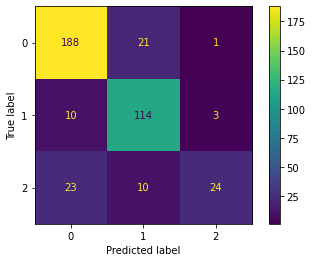

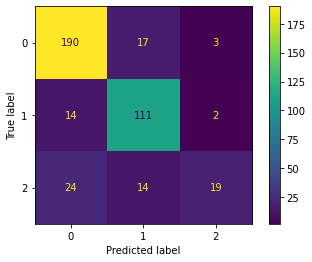

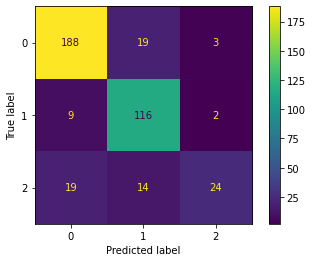

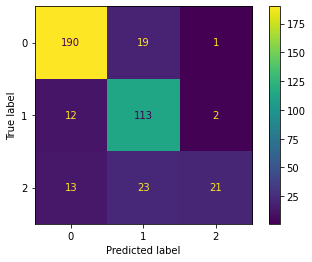

In [150]:
# Parameters of the run
rand_state = 18039
max_cat_samples = 2000 # Any more samples than this and we drop them

# Data splitter
splitter = model_selection.StratifiedShuffleSplit(n_splits = 4, test_size = 0.2, random_state = rand_state)

# Current data to use
these_data = cls_tokens_1[:2000].copy()

do_binary = True

if do_binary:
    # Binarize the data
    these_data = these_data > 0

def buildPreproc(x, binarized = False):
    """
    Build a preprocessing function
    """
    # Initial build of the two components in preprocessing
    scaler = preprocessing.StandardScaler().fit(x)

    def preproc(y):
        # Build preprocessing functions
        return scaler.transform(y)
        
    # If data is binarized, do nothing
    if binarized:
        def preproc(y):
            return y
    
    return preproc        

# Get the labels for the current tokens to be considered
these_labels = itc_labels_l1_factorized[:len(these_data)]


# Custom filter for data selection
these_data_temp = []
these_labels_temp = []
for i in np.unique(these_labels):
    inds_all = np.argwhere(these_labels == i)[:,0][:max_cat_samples]
    these_data_temp.append(these_data[inds_all])
    these_labels_temp.append(these_labels[inds_all])

these_data = np.concatenate(these_data_temp, axis = 0)
these_labels = np.concatenate(these_labels_temp, axis = 0)

# Pre-filtering data
unique_labels, unique_label_counts = np.unique(these_labels, return_counts = True)
print({q: v for q, v in zip(unique_labels, unique_label_counts)})

# Filter by count threshold
for ulbl, ulbl_count in zip(unique_labels, unique_label_counts):
    if ulbl_count < 100:
        these_data = these_data[these_labels != ulbl]
        these_labels = these_labels[these_labels != ulbl]

# Post filtering data
unique_labels, unique_label_counts = np.unique(these_labels, return_counts = True)
print("Post-filter")
print({q: v for q, v in zip(unique_labels, unique_label_counts)})

# Build the classifier(s)
clf_list = {}
# clfLR = linear_model.LogisticRegression(random_state = rand_state, max_iter = 1000)
# clf_list['LinReg'] = clfLR
# clfET = ensemble.ExtraTreesClassifier(random_state = rand_state, min_samples_split = 4, n_estimators = 100)
# clf_list['ET'] = clfET
# clfMLP = neural_network.MLPClassifier([384, 128], random_state = rand_state)
# clf_list['MLP'] = clfMLP
clfKNN = neighbors.KNeighborsClassifier()
clf_list['KNN'] = clfKNN

# Dictionary that we'll store scores into
scores_all = {}
for mtype in clf_list:
    clf = clf_list[mtype]
    # Loop through splits and store scores of trained classifier. Plot confusion matrix for each as well
    scores = []
    for i, (train_index, test_index) in enumerate(splitter.split(these_data, these_labels)):
        X, y = these_data[train_index], these_labels[train_index]

        # Build preprocessor
        preproc = buildPreproc(X, binarized = do_binary)
        
        # Scaling
        clf = clf.fit(preproc(X), y)

        # Test data
        X_t, y_t = these_data[test_index], these_labels[test_index]

        # Scaling
        scores.append(clf.score(preproc(X_t), y_t))

        # Confusion matrix generation
        confmat = metrics.confusion_matrix(y_t, clf.predict(preproc(X_t)), labels=clf.classes_)
        disp = metrics.ConfusionMatrixDisplay(confusion_matrix=confmat, display_labels=clf.classes_)
        disp.plot()

    # Integrate the scores together
    scores_all[mtype] = {'avg': np.mean(scores).round(3), 'cv_std': np.std(np.array(scores)).round(3)}
    
pprint.pprint(scores_all)
# print(metrics.accuracy_score(y_t, np.ones_like(y_t) * np.mean(y)))

# embed = manifold.TSNE().fit_transform(cls_tokens)
del these_data, these_labels

In [154]:
print(np.log(14e9), np.log(120e3))

23.36232316656167 11.695247021764184


In [157]:
2**16

65536

In [159]:
2**13

8192